This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) routines which are designed for noisy functions and compare to a brute-force parallel grid search.  

In [1]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4fisheries
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4fisheries (pyproject.toml) ... done
  Created wheel for rl4fisheries: filename=rl4fisheries-1.0.0-0.editable-py3-none-any.whl size=2176 sha256=d028c16eae2d3426770ee0d457b095dbc6d1476bd99367fb39a8cb750c74ca04
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghrv1awz/wheels/d3/ce/fe/d5af67bb4edf309f6a59d59140b2b78d5a336b2ad4b93a1fb4
Successfully built rl4fisheries
  Attempting uninstall: rl4fisheries
    Found existing installation: rl4fisheries 1.0.0
    Uninstalling rl4fisheries-1.0.0:
      Successfully uninstalled rl4fisheries-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
from rl4fisheries.asm import Asm
import numpy as np

In [4]:
env = Asm()

In [5]:
class fixed_effort:
    def __init__(self, effort):
        self.effort = effort[0]

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        action = np.array([action], dtype=np.float32)
        return action, {}

In [50]:
def f(x):
    results = []
    agent = fixed_effort([x])    
    for rep in range(50): # try score as average of 100 replicates, still a noisy measure
        episode_reward = 0.0
        observation, _ = env.reset()
        for t in range(env.Tmax):
            action, _ = agent.predict(observation, deterministic=True)
            observation, reward, terminated, done, info = env.step(action)
            episode_reward += reward
            if terminated or done:
                break
        results.append(episode_reward)      
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return [x, y, ymin, ymax]
    

In [51]:
f(0.05), f(0.06)

([0.05, 41.8499342139083, 27.78340382949657, 55.916464598320026],
 [0.06, 43.844054614982596, 29.955197024175753, 57.73291220578944])

In [54]:
import ray

@ray.remote
def ff(x):
    return f(x)

# formulate as matrix of values
effort = np.linspace(0,.25,501)
data = [ff.remote(i) for i in effort]
data = ray.get(data)


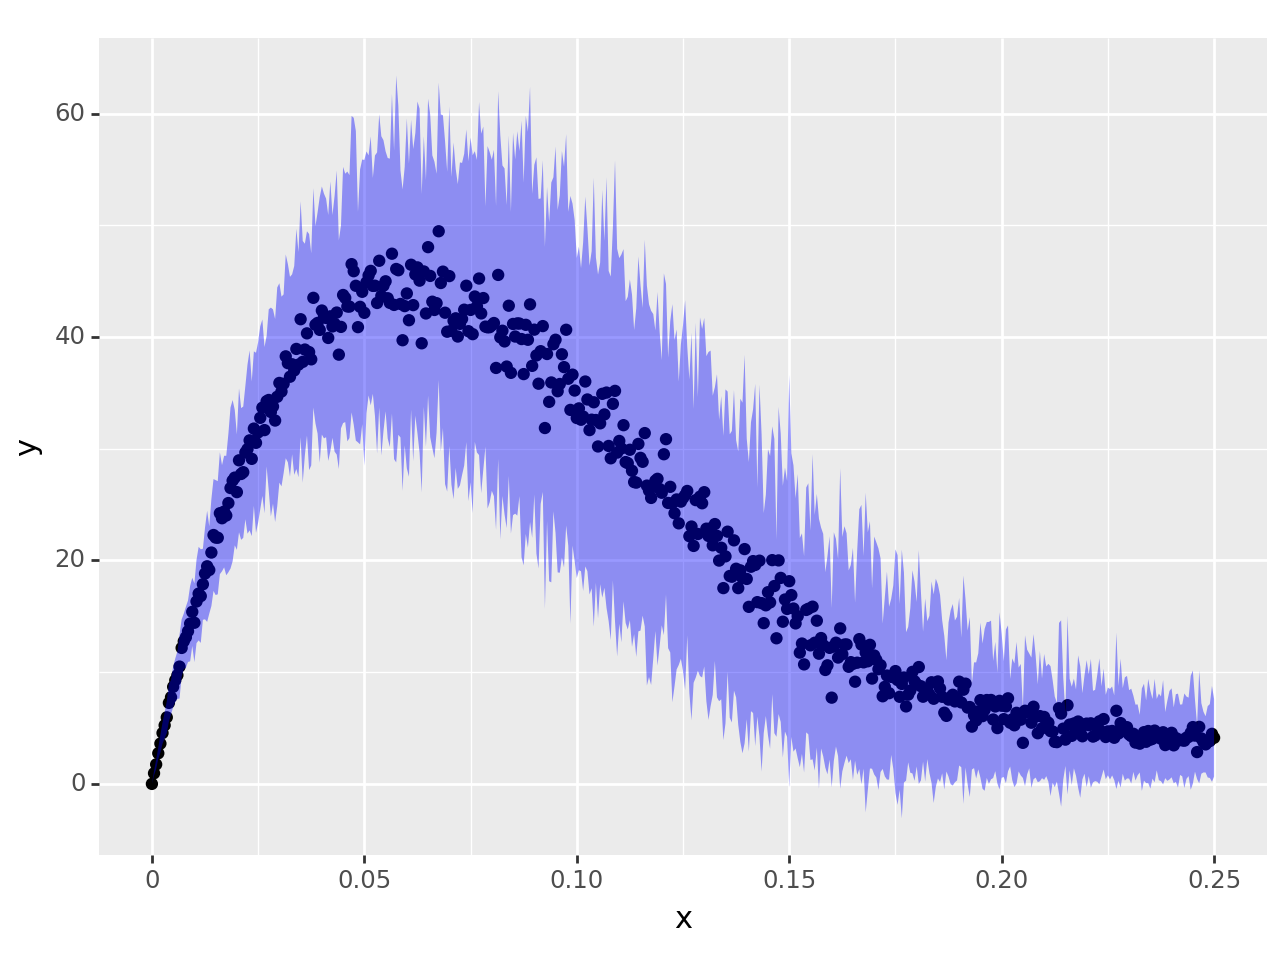

<Figure Size: (640 x 480)>

In [56]:
import polars as pl
df = pl.from_records(data, schema=["x", "y", "ymin", "ymax"])


from plotnine import ggplot, aes, geom_point, geom_ribbon

ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

In [63]:
def g(x):
    out = f(x[0])
    return - out[1]

In [ ]:
from skopt import gp_minimize
res = gp_minimize(g, [(0.02, 0.2)], n_calls = 100)
res.x

In [ ]:
from skopt import gbrt_minimize
res2 = gbrt_minimize(g, [(0.02, 0.15)], n_calls = 100)
res2.x